## **CS510: Deep Learning HW1: FashionMNIST**<br>
Winter 2021, Portland State University<br>
Steve Braich

Assignment Description:<br>
https://web.cecs.pdx.edu/~singh/courses/winter21/dl/a1w21.pdf <br>
"*The goal here is to implement a fully connected NN to classify images and basically learn how its performance is affected by choices of different parameters and data.*"<br>
...<br>
***DO NOT use a CNN. This has to be a fully-connected network***

## **1.	Resources**

Github Repo:
 - https://github.com/steve3p0/cs510dl

Sources:
 - Learning PyTorch with Examples:<br>
   https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
   
 - Explore NN with PyTorch" by Grecnik on Kaggle:<br>
   https://www.kaggle.com/nikitagrec/explore-nn-with-pytorch

 - "The curious case of the vanishing & exploding gradient" by Emma Amor<br>
   https://medium.com/ml-cheat-sheet/how-to-avoid-the-vanishing-exploding-gradients-problem-f9ccb4446c5a


###**Datasets**<br>
The data used to train the models in this notebook is from the Fashion MNIST dataset on Kagggle: <br>
https://www.kaggle.com/zalando-research/fashionmnist

You must have the following files in your local directory. You can get the first two from the Kaggle Dataset website.  

In [1]:
test_file  = 'fashion-mnist_test.csv'
train_file = 'fashion-mnist_train.csv'

###**Data pollution**<br>
In order to run step #4, a polluted training dataset was created from 'fashion-mnist-train.csv' with 1% pollution as defined in the assignment description:<br>
"*Pick 9 sets of 1% of images from each of the 10 categories and add them to the other 9 categories.*"

In [2]:
train_file_polluted = 'fashion-mnist_train_polluted.csv'

###**Location of data files:**<br>
This code checks to see if this notebook is running in Google Colab and if so it attempts to mount a drive to where the data is stored.

Modify this code as necessary so that you can access the data files.

In [3]:
import os
if 'COLAB_GPU' in os.environ:
    print("I'm running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/My\ Drive/Colab\ Notebooks/cs510dl/hw1
else: 
    print("I'm not running on Google Colab")

I'm not running on Google Colab


Verify if test, train, and polluted data files exist.

In [4]:
from os import path

# for dirname, _, filenames in os.walk('.'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# print()

print(f"Located: {test_file}") if path.isfile(test_file) else print(f"{test_file} not found")  
print(f"Located: {train_file}") if path.isfile(train_file) else print(f"{train_file} not found")  
print(f"Located: {train_file_polluted}") if path.isfile(train_file_polluted) else print(f"{train_file_polluted} not found")  

Located: fashion-mnist_test.csv
Located: fashion-mnist_train.csv
Located: fashion-mnist_train_polluted.csv


Let's import some libraries that were are going to need.

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

Let's take a look at the data.

In [6]:
data = pd.read_csv(test_file)
data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0


Now data transform to show examples of dataset:

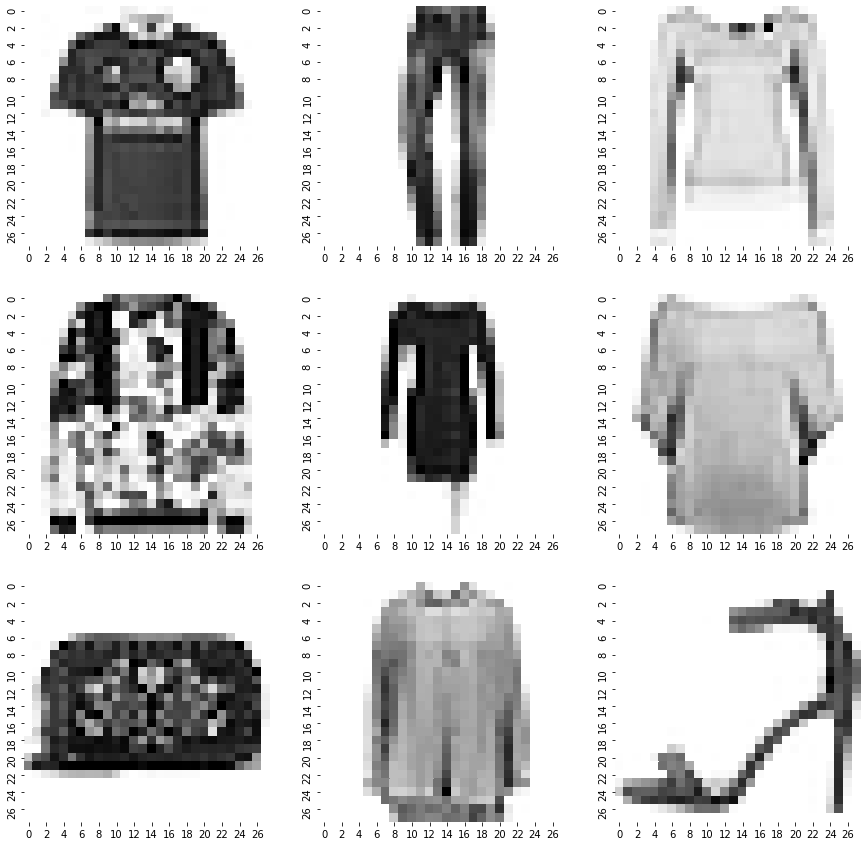

In [7]:
fig = plt.figure(figsize=(15,15))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    # sns.heatmap(np.array(data.iloc[i-1,1:]).reshape(28,28), cbar=False);
    sns.heatmap(np.array(data.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

Class object inherited from Dataset used to transform Fashing MNIST data

In [8]:
class FashionWear(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

Let's load the FashionMNIST data and normailize it.

In [9]:
data = pd.read_csv(test_file)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean / 225,), (std / 225,))])

data_test  = FashionWear(pd.read_csv(test_file),transform=transf)
data_train = FashionWear(pd.read_csv(train_file),transform=transf)

Now create class Net, which is inherited from class nn.Module. Fistly, try simple architecture, without Conv and Pooling. This architecture has three linear layers. In **init** method we define all unique NN parameters, and in **forward** we define NN architecture.

In [10]:
class FashionNetwork(torch.nn.Module):
    """
    FashionNetwork is the class object used to propagate thru our network
    """

    def __init__(self, hidden_size: List, activation):
        super().__init__()

        # These aren't going to change
        self.INPUT_SIZE = 784
        self.hidden_size = hidden_size
        self.OUTPUT_SIZE = 10

        self.activation = activation

        # define modules in our Fully Connect (FC) Layers
        modules = []
        modules.append(nn.Linear(in_features=self.INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=self.OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

FashionModel is the class object that encapsulates our model

In [11]:
class FashionModel():
    """
    FashionModel is the class object that encapsulates our model
    """

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def test(self) -> None:
        """
        Evaluate a model
        """

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        """
        Train a fully connected neural network classifier on a dataset of fashion images
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = FashionNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        # Print Training Parameters
        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print("------------------------------------------------------------------------------------------")

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)

                # Forward pass
                output = self.model(image)

                loss = self.criterion(output, label)
                loss = loss.to()
                # Initializing a gradient as 0 so there is no mixing of gradient among the batches
                optimizer.zero_grad()

                # Propagating the error backward
                loss.backward()

                # Prevent Gradient Explosion
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

                # Optimizing the parameters
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            # print(f"Epoch {epoch}/{epochs}  Train Loss: {loss.item():.4f}   Train Accuracy: {accuracy:.2f}%   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

## **2.	Exploring NN Accuracy**
Comparison of Two Fully Connected Networks

We were tasked with training and comparing two fully connected NN classifiers for recognizing images of clothing as specified by the Fashion MNIST data.  Both networks shared the following hyperparameters and only differed by their number of hidden layers.  Model A had only one hidden layer and Model B had two. The input vector has 784 cells that represent a 28 x 28 pixelated image of clothing. 


In [12]:
# EPOCHS = 1
# EPOCHS = 2
EPOCHS = 20

Let's first train up Model A below:

In [13]:
# Model A
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = EPOCHS

# Train Model A
model_a = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_a.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.7821    Testing Loss: 0.8884    Testing Accuracy: 74.67%
Epoch 2/20  Training Loss: 0.6667    Testing Loss: 1.1231    Testing Accuracy: 78.43%
Epoch 3/20  Training Loss: 0.4167    Testing Loss: 0.4878    Testing Accuracy: 80.26%
Epoch 4/20  Training Loss: 0.5272    Testing Loss: 0.5241    Testing Accuracy: 81.31%
Epoch 5/20  Training Loss: 0.5201    Testing Loss: 0.6363    Testing Accuracy: 82.21%
Epoch 6/20  Training Loss: 0.4744    Testing Loss: 0.3030    Testing Accuracy: 82.86%
Epoch 7/20  Training Loss: 0.3417    Testing Loss: 0.5251    Testing Accuracy: 83.31%
Epoch 8/20  Training Loss: 0.3907    Testing Loss: 0.1631    Testing Accuracy: 83.76%
Epoch 9/20  Training Loss: 0.2643    Testing Loss: 0.4149    Testing Accuracy: 84.0%
Epoch 10/20  Training Loss: 0.4126 

Next, let's train up Model B.  It has just one more hidden layer than Model A:

In [14]:
hidden_size = (1024, 1024)
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = EPOCHS

# Train the model
model_b = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_b.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.8263    Testing Loss: 0.6855    Testing Accuracy: 72.0%
Epoch 2/20  Training Loss: 0.8926    Testing Loss: 0.8610    Testing Accuracy: 75.58%
Epoch 3/20  Training Loss: 0.5247    Testing Loss: 0.9023    Testing Accuracy: 77.92%
Epoch 4/20  Training Loss: 0.8019    Testing Loss: 0.5693    Testing Accuracy: 79.58%
Epoch 5/20  Training Loss: 0.7109    Testing Loss: 0.4300    Testing Accuracy: 80.87%
Epoch 6/20  Training Loss: 0.3158    Testing Loss: 0.9558    Testing Accuracy: 81.63%
Epoch 7/20  Training Loss: 0.4901    Testing Loss: 0.2491    Testing Accuracy: 82.21%
Epoch 8/20  Training Loss: 0.4637    Testing Loss: 0.1677    Testing Accuracy: 82.75%
Epoch 9/20  Training Loss: 0.4721    Testing Loss: 0.3409    Testing Accuracy: 83.15%
Epoch 10/20  Training Loss: 0

Let's create a function to diplay multiple visualization for a model.
The function below will plot the accuracy, loss, and a confusion matrix with a headmap.

In [15]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.figsize'] = [25, 5]


def display_model_visuals(model, title):

    # Plot Accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # Plot Cross-Entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model_a.loss_test) + 1))
    plt.legend();

    # Create Confusion Matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()


### **Model Visualizations**
Will adding a layer improve accuracy?
Plot Accuracy, Cross-Entropy Loss and a Confusion Matrix for both Model A and B.

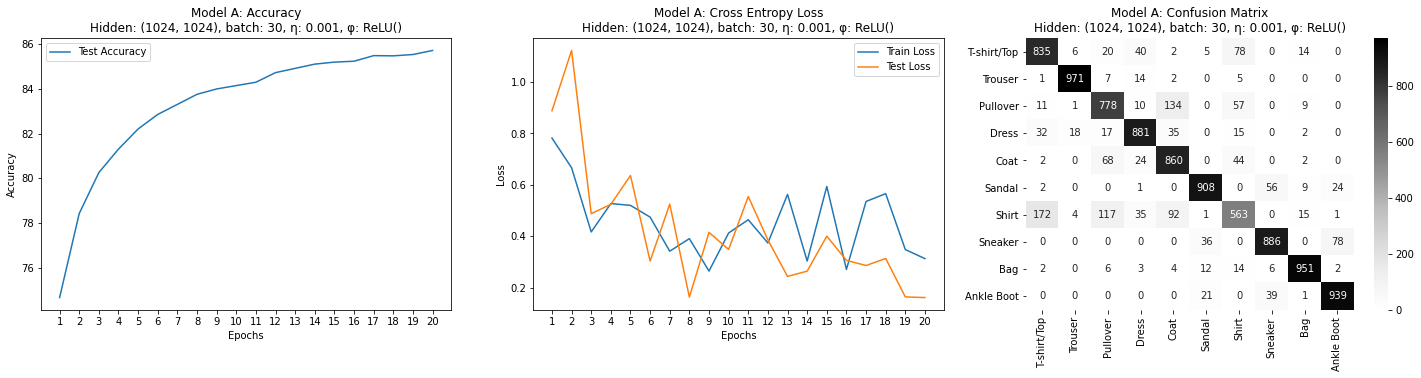

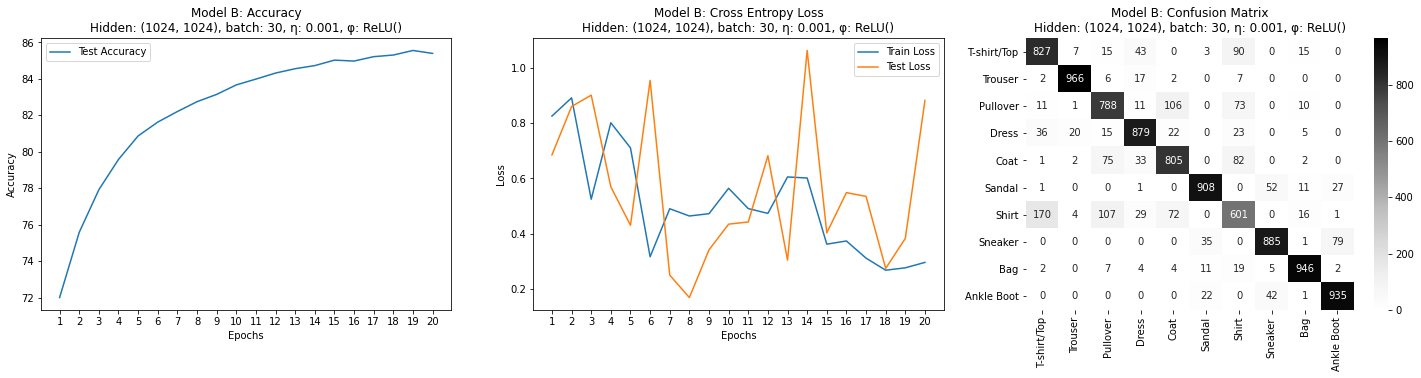

In [16]:
display_model_visuals(model_a, "Model A");
display_model_visuals(model_b, "Model B")

## **3. Best vs. Worst Case**
Right out the gate, I had a problem with our first configuration of hyperparameters. Model 1, 2, and 9 listed below were initially reporting training losses of NaN (not a number).  What was happening?  Upon careful study, it was  discovered that the Rectified Linear Unit (ReLU) activation function, with its unbounded upper limit, is susceptible to an explosive gradient, especially when its learning rate is high (in this case, 1.0, and 0.1).  The cross-entropy loss reported during testing was exceeding the upper bounds of python’s floating-point precision.  To solve this, I used gradient scaling, with a maximum norm of 2, to clip the gradient norm so that it stays within a reasonable range. It seems that a low ratio between the number of batches and the learning rate causes ReLU to “blow up”  the gradient.

In [17]:
# EPOCHS = 1
# EPOCHS = 2
EPOCHS = 20

**NOTE:** Keep in mind that the following code will produce visualizations for only the last epoch of each model. The last epoch might not have the highest accuracy.

3*4*2=24 Model Training - Started At: 01/25/2021 22:24:01
------------------------------------------------------------------------------------------
CASE: 01 Training Started: 01/25/2021 22:24:01
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0000    Testing Loss: 3.0920    Testing Accuracy: 24.37%
Epoch 2/20  Training Loss: 2.1163    Testing Loss: 2.2822    Testing Accuracy: 27.6%
Epoch 3/20  Training Loss: 1.2330    Testing Loss: 2.7740    Testing Accuracy: 22.2%
Epoch 4/20  Training Loss: 1.4718    Testing Loss: 2.5257    Testing Accuracy: 19.21%
Epoch 5/20  Training Loss: 2.8913    Testing Loss: 0.0000    Testing Accuracy: 25.36%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 22.95%
Epoch 

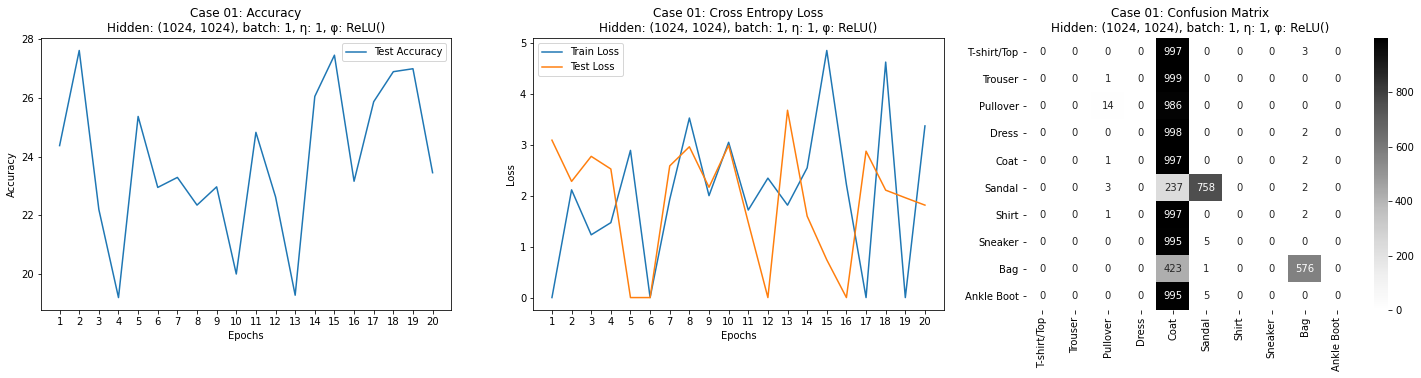

------------------------------------------------------------------------------------------
CASE: 02 Training Started: 01/25/2021 22:57:53
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 85.44%
Epoch 2/20  Training Loss: 0.0000    Testing Loss: 0.0001    Testing Accuracy: 86.65%
Epoch 3/20  Training Loss: 0.0001    Testing Loss: 5.3877    Testing Accuracy: 87.79%
Epoch 4/20  Training Loss: 0.0000    Testing Loss: 3.2290    Testing Accuracy: 87.96%
Epoch 5/20  Training Loss: 0.0000    Testing Loss: 1.8510    Testing Accuracy: 89.41%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 89.26%
Epoch 7/20  Training Loss: 0.0000    Testing Loss: 0.0000   

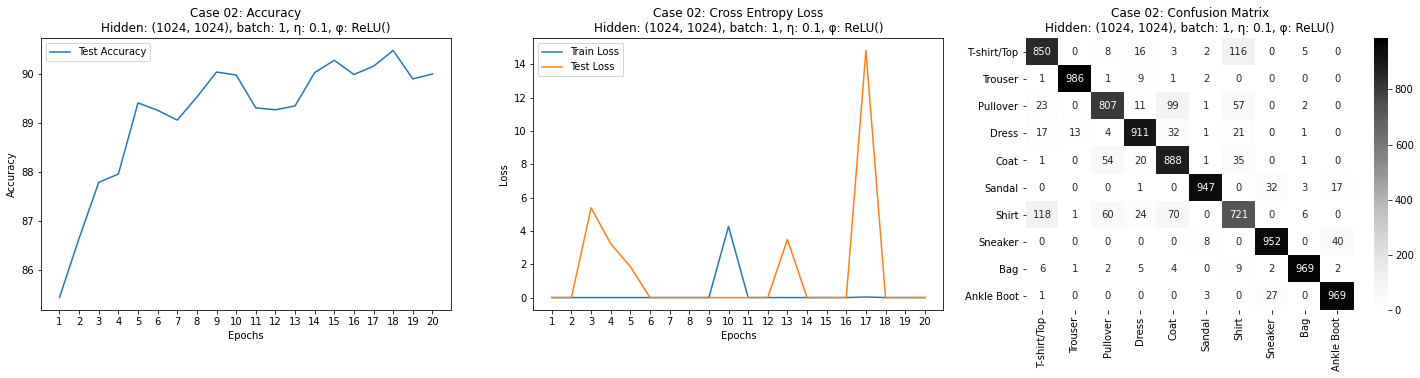

------------------------------------------------------------------------------------------
CASE: 03 Training Started: 01/25/2021 23:33:57
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0000    Testing Loss: 0.1513    Testing Accuracy: 85.0%
Epoch 2/20  Training Loss: 0.0000    Testing Loss: 0.0070    Testing Accuracy: 86.62%
Epoch 3/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 87.64%
Epoch 4/20  Training Loss: 0.0000    Testing Loss: 0.0008    Testing Accuracy: 88.36%
Epoch 5/20  Training Loss: 0.0002    Testing Loss: 0.0000    Testing Accuracy: 88.71%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 89.12%
Epoch 7/20  Training Loss: 0.0000    Testing Loss: 0.0000   

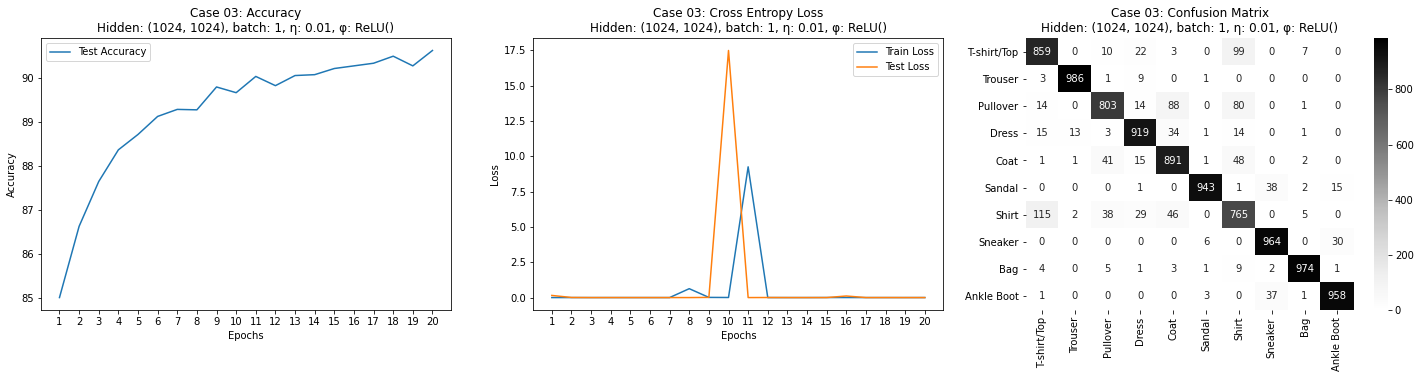

------------------------------------------------------------------------------------------
CASE: 04 Training Started: 01/26/2021 00:10:35
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0011    Testing Loss: 0.0082    Testing Accuracy: 78.02%
Epoch 2/20  Training Loss: 4.4547    Testing Loss: 0.0836    Testing Accuracy: 81.25%
Epoch 3/20  Training Loss: 5.2336    Testing Loss: 0.0028    Testing Accuracy: 82.97%
Epoch 4/20  Training Loss: 0.0001    Testing Loss: 0.0439    Testing Accuracy: 83.43%
Epoch 5/20  Training Loss: 0.0002    Testing Loss: 0.0008    Testing Accuracy: 84.21%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0015    Testing Accuracy: 84.98%
Epoch 7/20  Training Loss: 0.0000    Testing Loss: 0.0001 

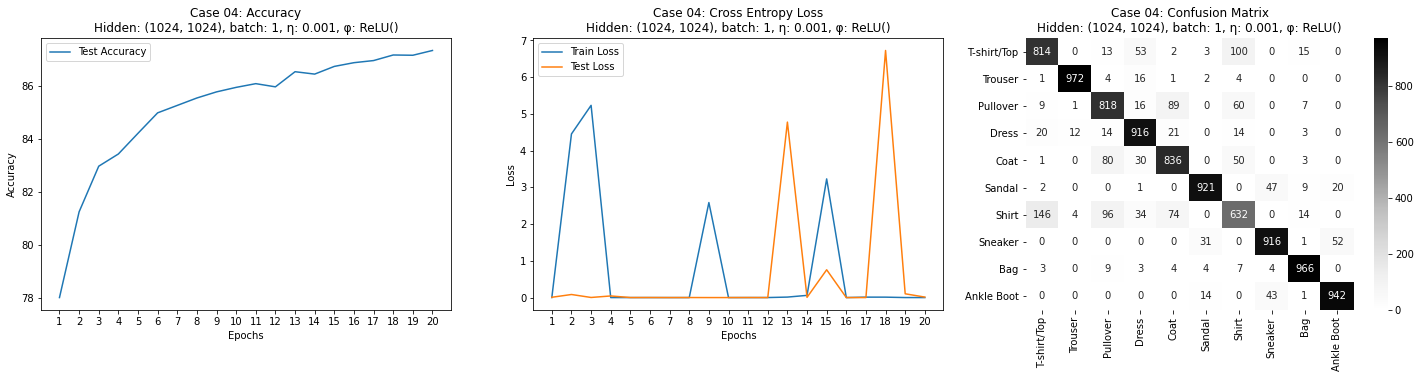

------------------------------------------------------------------------------------------
CASE: 05 Training Started: 01/26/2021 00:47:52
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0000    Testing Loss: 0.0004    Testing Accuracy: 74.19%
Epoch 2/20  Training Loss: 0.0000    Testing Loss: 7.6556    Testing Accuracy: 77.55%
Epoch 3/20  Training Loss: 0.7452    Testing Loss: 0.1019    Testing Accuracy: 81.06%
Epoch 4/20  Training Loss: 0.0000    Testing Loss: 13.4278    Testing Accuracy: 75.83%
Epoch 5/20  Training Loss: 0.0000    Testing Loss: 1.2081    Testing Accuracy: 79.83%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 79.53%
Epoch 7/20  Training Loss: 19.6257    Testing Loss: 0.0000

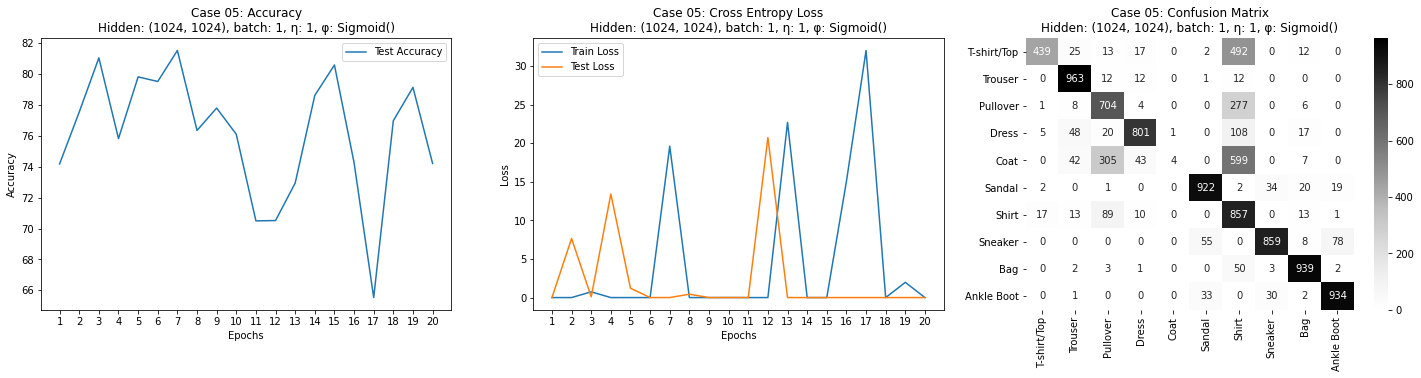

------------------------------------------------------------------------------------------
CASE: 06 Training Started: 01/26/2021 01:24:41
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.0000    Testing Loss: 0.0009    Testing Accuracy: 84.88%
Epoch 2/20  Training Loss: 1.4270    Testing Loss: 0.0010    Testing Accuracy: 86.0%
Epoch 3/20  Training Loss: 4.1333    Testing Loss: 0.0003    Testing Accuracy: 87.03%
Epoch 4/20  Training Loss: 5.3400    Testing Loss: 0.0015    Testing Accuracy: 87.84%
Epoch 5/20  Training Loss: 0.0001    Testing Loss: 0.0002    Testing Accuracy: 88.15%
Epoch 6/20  Training Loss: 0.1492    Testing Loss: 0.0001    Testing Accuracy: 88.88%
Epoch 7/20  Training Loss: 0.2989    Testing Loss: 0.0000 

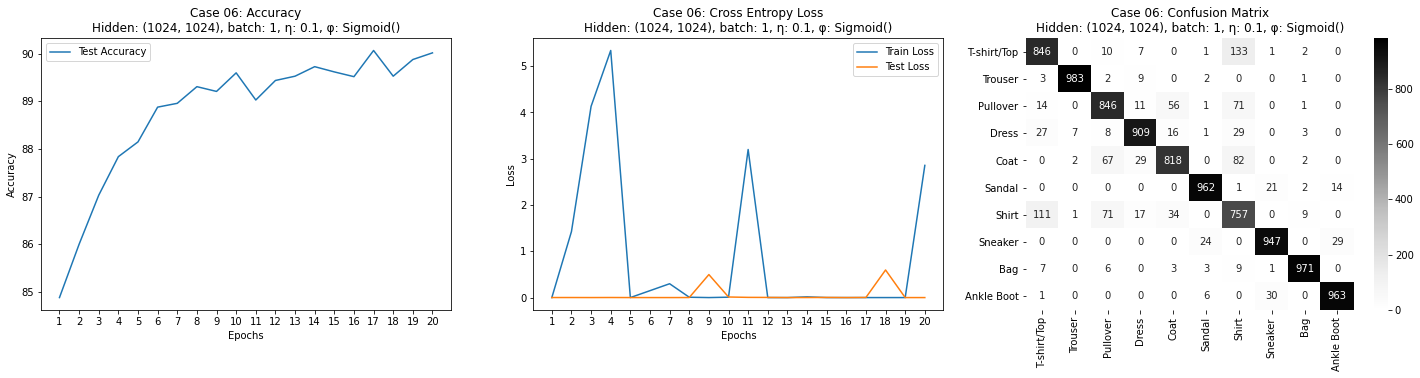

------------------------------------------------------------------------------------------
CASE: 07 Training Started: 01/26/2021 02:01:13
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 3.8959    Testing Loss: 0.0322    Testing Accuracy: 77.28%
Epoch 2/20  Training Loss: 0.0002    Testing Loss: 0.0725    Testing Accuracy: 81.0%
Epoch 3/20  Training Loss: 0.0802    Testing Loss: 1.4123    Testing Accuracy: 82.64%
Epoch 4/20  Training Loss: 0.0000    Testing Loss: 0.8929    Testing Accuracy: 84.22%
Epoch 5/20  Training Loss: 0.9751    Testing Loss: 6.5953    Testing Accuracy: 84.93%
Epoch 6/20  Training Loss: 0.0005    Testing Loss: 0.0002    Testing Accuracy: 85.59%
Epoch 7/20  Training Loss: 0.0006    Testing Loss: 0.0009

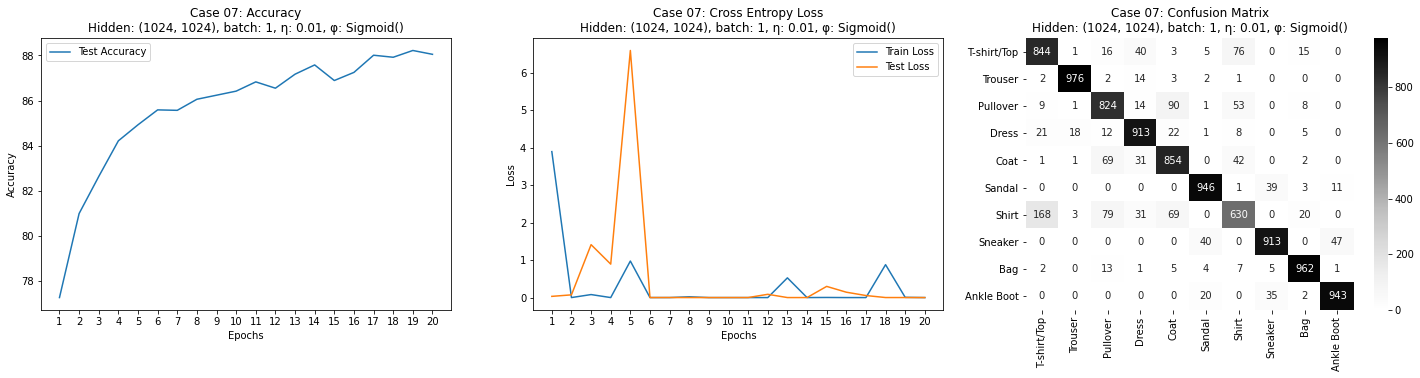

------------------------------------------------------------------------------------------
CASE: 08 Training Started: 01/26/2021 02:38:05
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 1.7484    Testing Loss: 1.6600    Testing Accuracy: 54.47%
Epoch 2/20  Training Loss: 1.7282    Testing Loss: 0.5234    Testing Accuracy: 53.02%
Epoch 3/20  Training Loss: 1.1308    Testing Loss: 1.7070    Testing Accuracy: 57.8%
Epoch 4/20  Training Loss: 1.8713    Testing Loss: 0.0109    Testing Accuracy: 68.16%
Epoch 5/20  Training Loss: 2.0083    Testing Loss: 0.5416    Testing Accuracy: 72.51%
Epoch 6/20  Training Loss: 0.0047    Testing Loss: 1.4833    Testing Accuracy: 73.68%
Epoch 7/20  Training Loss: 0.0049    Testing Loss: 3.168

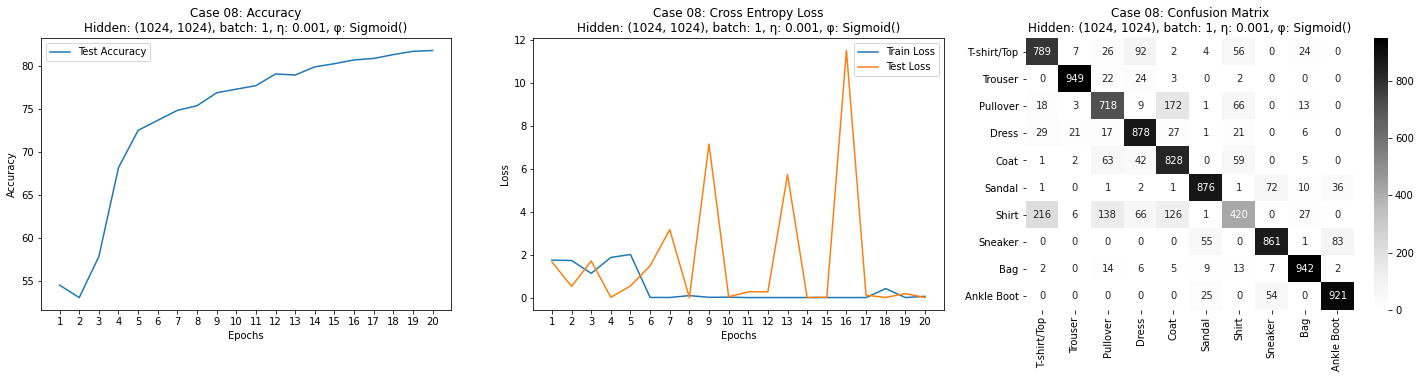

------------------------------------------------------------------------------------------
CASE: 09 Training Started: 01/26/2021 03:15:46
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 4.4889    Testing Loss: 1.5286    Testing Accuracy: 36.24%
Epoch 2/20  Training Loss: 2.0732    Testing Loss: 2.3366    Testing Accuracy: 27.3%
Epoch 3/20  Training Loss: 1.4648    Testing Loss: 1.5386    Testing Accuracy: 28.03%
Epoch 4/20  Training Loss: 1.5854    Testing Loss: 1.3779    Testing Accuracy: 27.77%
Epoch 5/20  Training Loss: 1.9956    Testing Loss: 1.5878    Testing Accuracy: 29.09%
Epoch 6/20  Training Loss: 1.5325    Testing Loss: 1.5601    Testing Accuracy: 23.29%
Epoch 7/20  Training Loss: 2.3435    Testing Loss: 2.7732    T

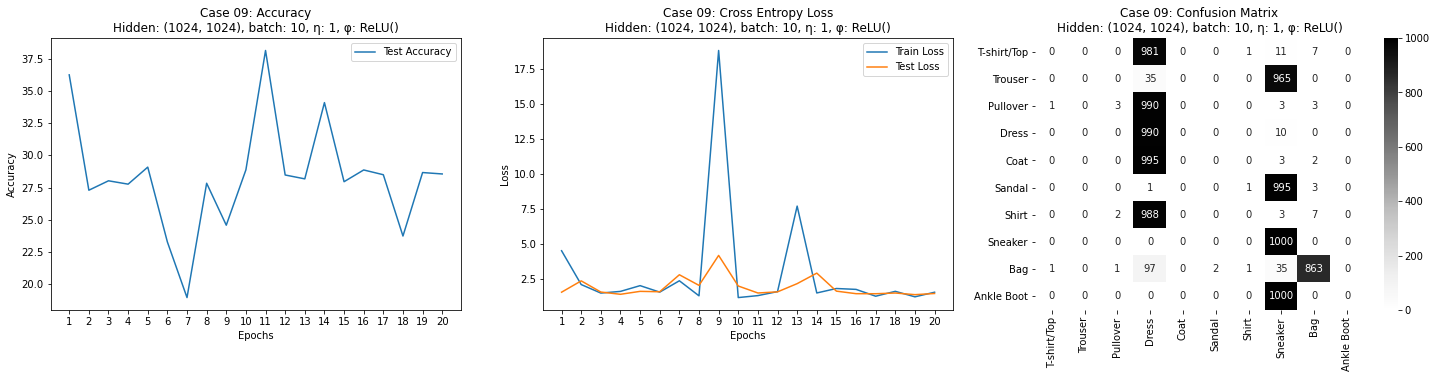

------------------------------------------------------------------------------------------
CASE: 10 Training Started: 01/26/2021 03:22:46
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.2796    Testing Loss: 0.4383    Testing Accuracy: 86.13%
Epoch 2/20  Training Loss: 0.9502    Testing Loss: 0.9274    Testing Accuracy: 86.96%
Epoch 3/20  Training Loss: 0.4341    Testing Loss: 0.4368    Testing Accuracy: 88.61%
Epoch 4/20  Training Loss: 0.2701    Testing Loss: 0.1473    Testing Accuracy: 89.47%
Epoch 5/20  Training Loss: 0.0922    Testing Loss: 0.2130    Testing Accuracy: 88.7%
Epoch 6/20  Training Loss: 0.1809    Testing Loss: 0.1652    Testing Accuracy: 89.26%
Epoch 7/20  Training Loss: 0.0446    Testing Loss: 0.0058   

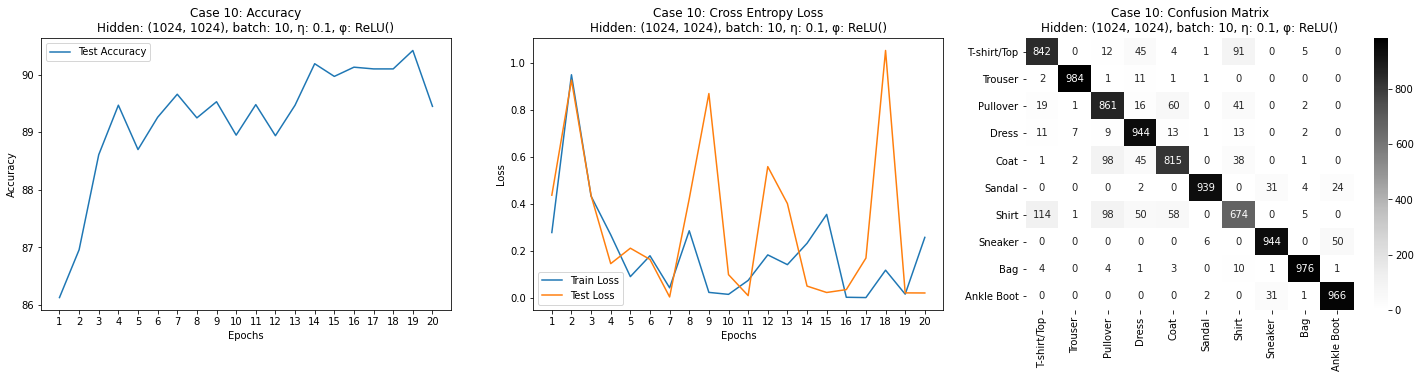

------------------------------------------------------------------------------------------
CASE: 11 Training Started: 01/26/2021 03:29:52
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.3520    Testing Loss: 0.1773    Testing Accuracy: 84.15%
Epoch 2/20  Training Loss: 0.2462    Testing Loss: 0.1948    Testing Accuracy: 86.16%
Epoch 3/20  Training Loss: 0.5668    Testing Loss: 0.0766    Testing Accuracy: 86.47%
Epoch 4/20  Training Loss: 0.8835    Testing Loss: 1.0641    Testing Accuracy: 87.46%
Epoch 5/20  Training Loss: 0.1466    Testing Loss: 0.5259    Testing Accuracy: 88.13%
Epoch 6/20  Training Loss: 0.0433    Testing Loss: 0.0978    Testing Accuracy: 88.2%
Epoch 7/20  Training Loss: 0.1866    Testing Loss: 0.1584  

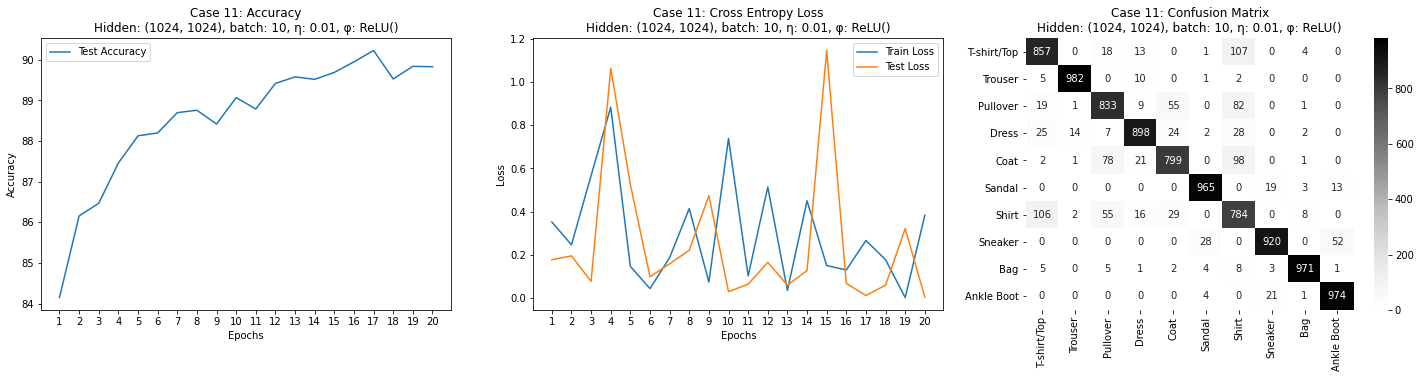

------------------------------------------------------------------------------------------
CASE: 12 Training Started: 01/26/2021 03:37:04
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.5894    Testing Loss: 0.6365    Testing Accuracy: 75.9%
Epoch 2/20  Training Loss: 0.7909    Testing Loss: 0.7461    Testing Accuracy: 79.13%
Epoch 3/20  Training Loss: 0.6375    Testing Loss: 0.3008    Testing Accuracy: 81.27%
Epoch 4/20  Training Loss: 0.5940    Testing Loss: 0.1281    Testing Accuracy: 82.13%
Epoch 5/20  Training Loss: 0.2055    Testing Loss: 0.4530    Testing Accuracy: 83.28%
Epoch 6/20  Training Loss: 0.1708    Testing Loss: 0.5030    Testing Accuracy: 83.92%
Epoch 7/20  Training Loss: 0.2352    Testing Loss: 1.0286 

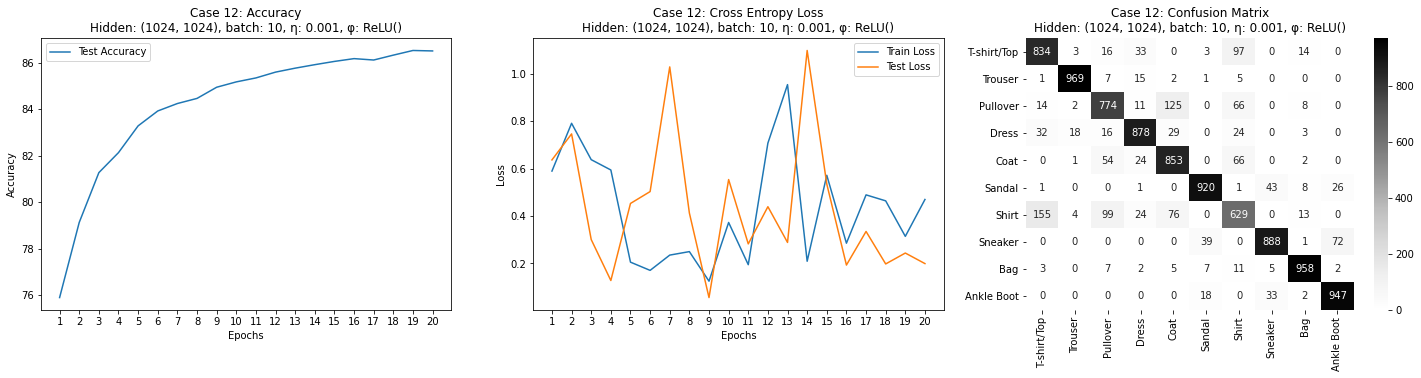

------------------------------------------------------------------------------------------
CASE: 13 Training Started: 01/26/2021 03:44:19
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.2918    Testing Loss: 1.0860    Testing Accuracy: 80.46%
Epoch 2/20  Training Loss: 0.2419    Testing Loss: 0.9526    Testing Accuracy: 84.72%
Epoch 3/20  Training Loss: 0.6182    Testing Loss: 0.2000    Testing Accuracy: 85.7%
Epoch 4/20  Training Loss: 0.3550    Testing Loss: 0.1165    Testing Accuracy: 85.76%
Epoch 5/20  Training Loss: 0.0837    Testing Loss: 0.6378    Testing Accuracy: 87.8%
Epoch 6/20  Training Loss: 0.5331    Testing Loss: 0.5536    Testing Accuracy: 87.72%
Epoch 7/20  Training Loss: 1.1088    Testing Loss: 0.1265   

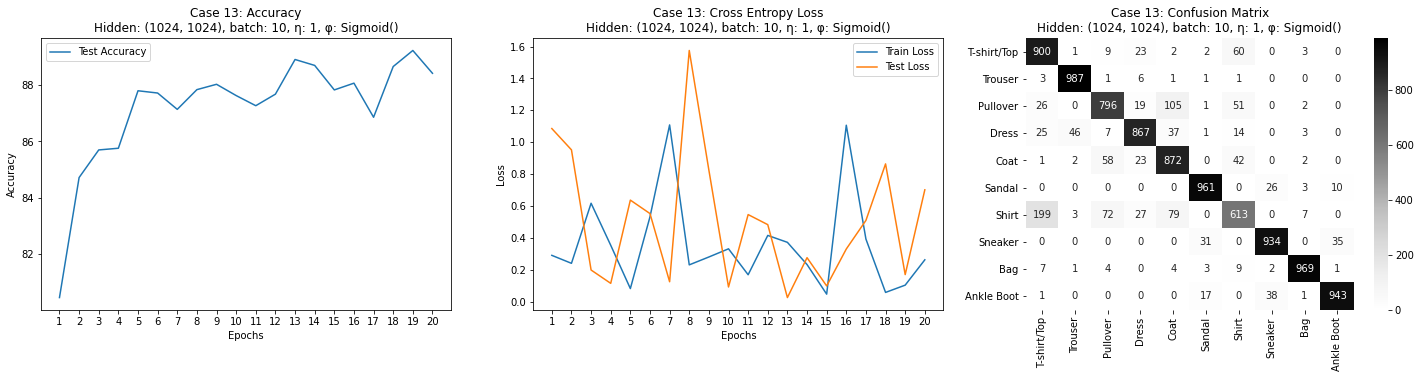

------------------------------------------------------------------------------------------
CASE: 14 Training Started: 01/26/2021 03:51:16
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.6243    Testing Loss: 0.1685    Testing Accuracy: 82.45%
Epoch 2/20  Training Loss: 0.1275    Testing Loss: 0.4169    Testing Accuracy: 83.37%
Epoch 3/20  Training Loss: 0.3155    Testing Loss: 0.4776    Testing Accuracy: 85.89%
Epoch 4/20  Training Loss: 0.2135    Testing Loss: 0.1323    Testing Accuracy: 86.16%
Epoch 5/20  Training Loss: 0.2284    Testing Loss: 0.0767    Testing Accuracy: 86.78%
Epoch 6/20  Training Loss: 0.0346    Testing Loss: 0.6947    Testing Accuracy: 87.59%
Epoch 7/20  Training Loss: 0.2259    Testing Loss: 0.283

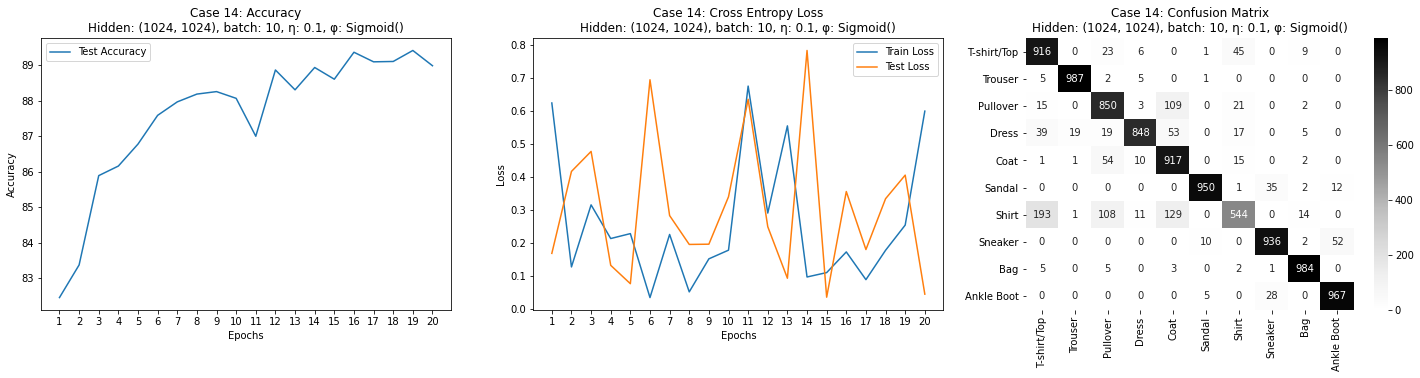

------------------------------------------------------------------------------------------
CASE: 15 Training Started: 01/26/2021 03:58:21
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 1.1092    Testing Loss: 0.7908    Testing Accuracy: 65.37%
Epoch 2/20  Training Loss: 1.0260    Testing Loss: 0.6421    Testing Accuracy: 74.61%
Epoch 3/20  Training Loss: 0.2239    Testing Loss: 0.5422    Testing Accuracy: 78.02%
Epoch 4/20  Training Loss: 0.4206    Testing Loss: 0.2241    Testing Accuracy: 81.31%
Epoch 5/20  Training Loss: 0.4003    Testing Loss: 0.3240    Testing Accuracy: 82.29%
Epoch 6/20  Training Loss: 1.0020    Testing Loss: 0.8749    Testing Accuracy: 83.57%
Epoch 7/20  Training Loss: 0.4707    Testing Loss: 0.90

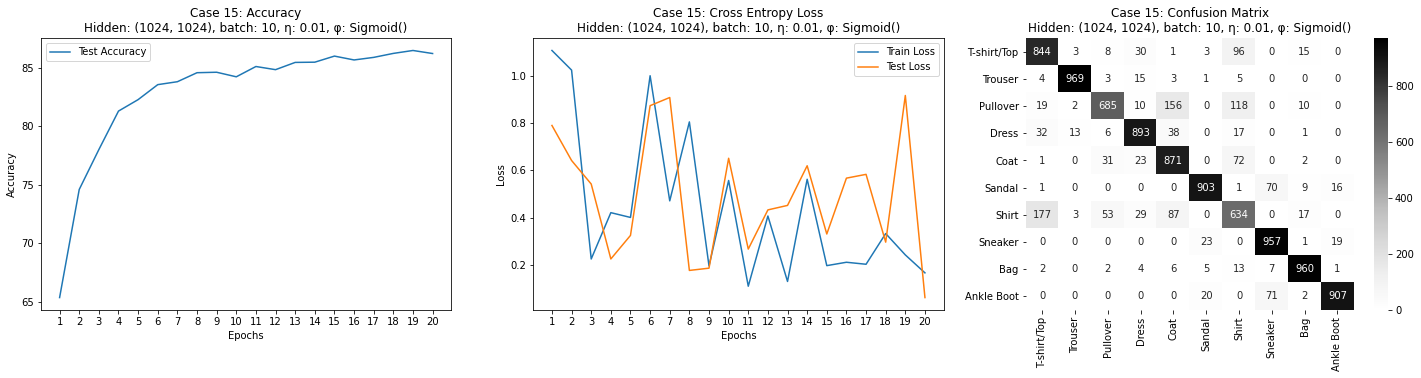

------------------------------------------------------------------------------------------
CASE: 16 Training Started: 01/26/2021 04:05:37
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    10
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 2.2236    Testing Loss: 2.2243    Testing Accuracy: 34.95%
Epoch 2/20  Training Loss: 2.1347    Testing Loss: 2.1533    Testing Accuracy: 45.92%
Epoch 3/20  Training Loss: 1.8285    Testing Loss: 1.9088    Testing Accuracy: 52.96%
Epoch 4/20  Training Loss: 1.7016    Testing Loss: 1.7242    Testing Accuracy: 58.0%
Epoch 5/20  Training Loss: 1.5964    Testing Loss: 1.2375    Testing Accuracy: 56.9%
Epoch 6/20  Training Loss: 1.2114    Testing Loss: 1.1130    Testing Accuracy: 59.07%
Epoch 7/20  Training Loss: 1.8332    Testing Loss: 1.405

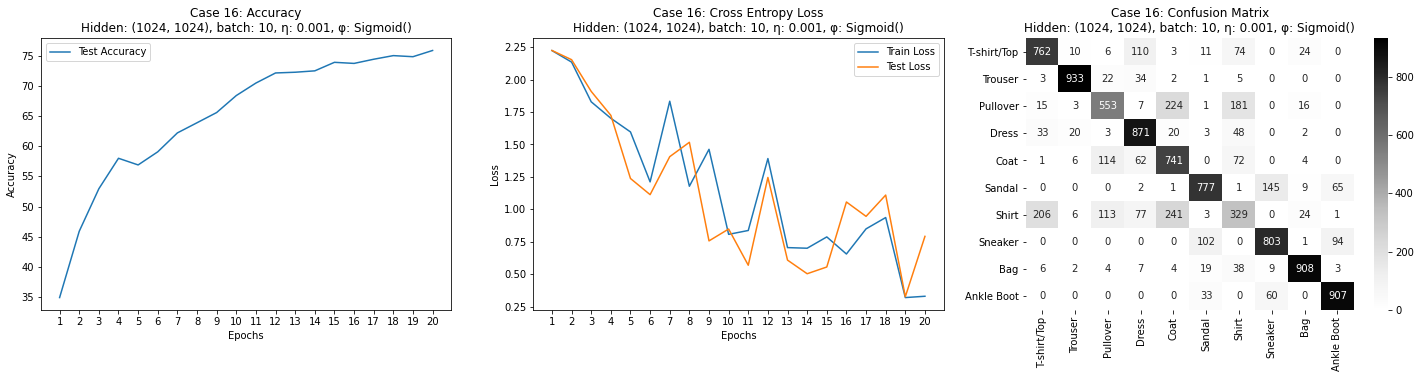

------------------------------------------------------------------------------------------
CASE: 17 Training Started: 01/26/2021 04:12:56
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.7307    Testing Loss: 0.7380    Testing Accuracy: 66.26%
Epoch 2/20  Training Loss: 0.6169    Testing Loss: 0.5673    Testing Accuracy: 77.39%
Epoch 3/20  Training Loss: 0.4568    Testing Loss: 0.4896    Testing Accuracy: 81.3%
Epoch 4/20  Training Loss: 0.4135    Testing Loss: 0.4309    Testing Accuracy: 85.18%
Epoch 5/20  Training Loss: 0.3643    Testing Loss: 0.3551    Testing Accuracy: 86.05%
Epoch 6/20  Training Loss: 0.3786    Testing Loss: 0.4010    Testing Accuracy: 85.14%
Epoch 7/20  Training Loss: 0.3554    Testing Loss: 0.3497   

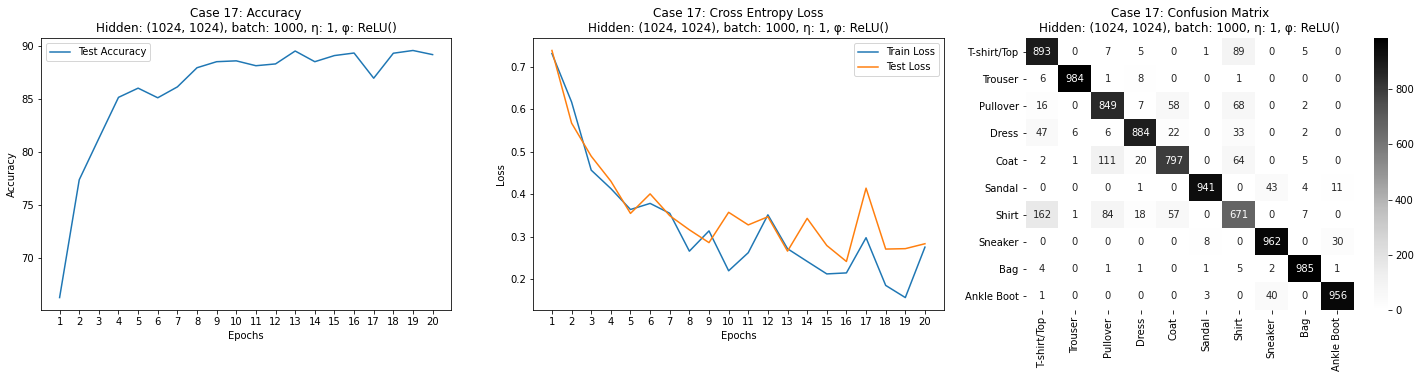

------------------------------------------------------------------------------------------
CASE: 18 Training Started: 01/26/2021 04:16:28
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.7155    Testing Loss: 0.6518    Testing Accuracy: 73.85%
Epoch 2/20  Training Loss: 0.4699    Testing Loss: 0.5093    Testing Accuracy: 81.34%
Epoch 3/20  Training Loss: 0.5057    Testing Loss: 0.4648    Testing Accuracy: 82.16%
Epoch 4/20  Training Loss: 0.4631    Testing Loss: 0.5059    Testing Accuracy: 82.53%
Epoch 5/20  Training Loss: 0.4408    Testing Loss: 0.4320    Testing Accuracy: 84.91%
Epoch 6/20  Training Loss: 0.3842    Testing Loss: 0.3841    Testing Accuracy: 84.5%
Epoch 7/20  Training Loss: 0.3893    Testing Loss: 0.4388 

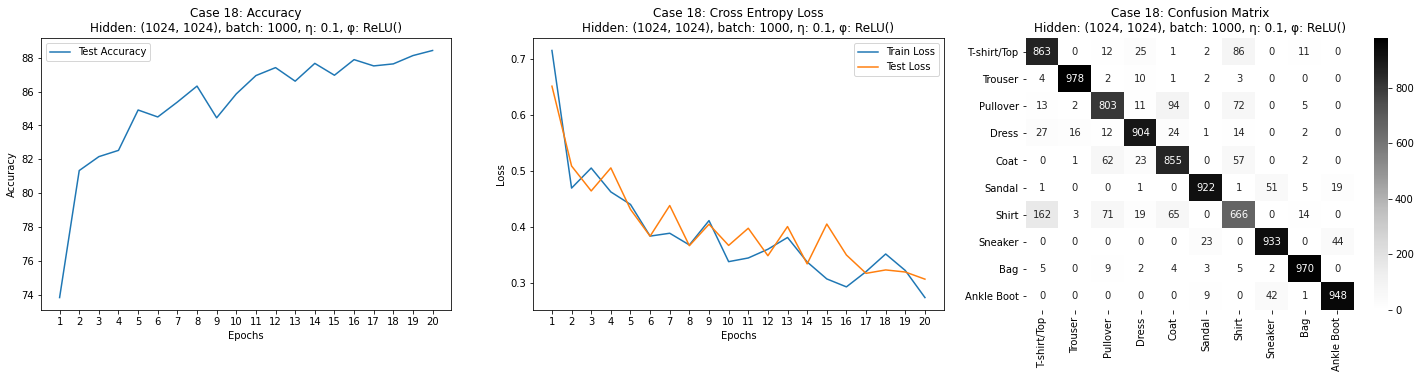

------------------------------------------------------------------------------------------
CASE: 19 Training Started: 01/26/2021 04:20:00
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 1.6807    Testing Loss: 1.6644    Testing Accuracy: 61.2%
Epoch 2/20  Training Loss: 1.1684    Testing Loss: 1.1359    Testing Accuracy: 69.2%
Epoch 3/20  Training Loss: 0.9007    Testing Loss: 0.9664    Testing Accuracy: 71.8%
Epoch 4/20  Training Loss: 0.8003    Testing Loss: 0.8075    Testing Accuracy: 73.61%
Epoch 5/20  Training Loss: 0.7419    Testing Loss: 0.7551    Testing Accuracy: 74.87%
Epoch 6/20  Training Loss: 0.7064    Testing Loss: 0.7260    Testing Accuracy: 75.42%
Epoch 7/20  Training Loss: 0.6604    Testing Loss: 0.6454  

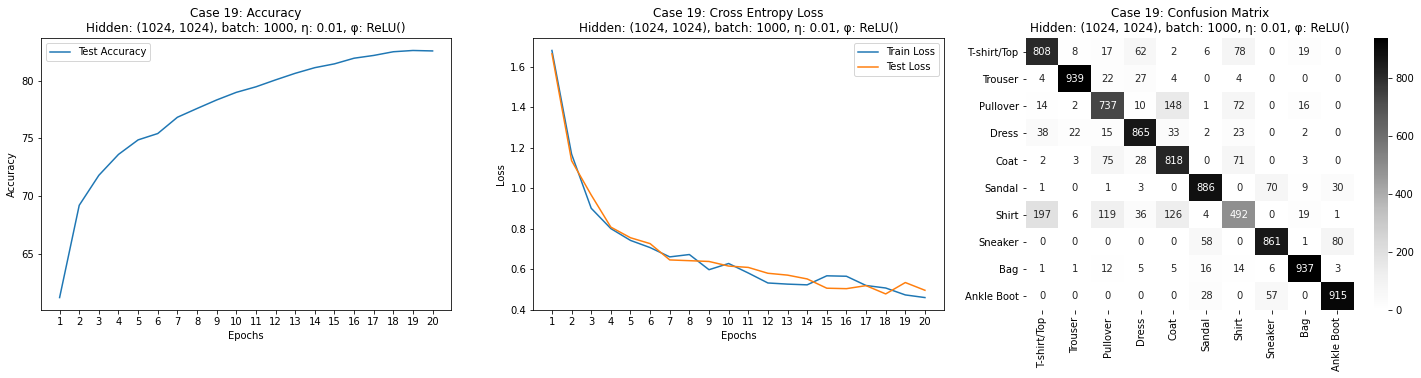

------------------------------------------------------------------------------------------
CASE: 20 Training Started: 01/26/2021 04:23:32
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 2.2537    Testing Loss: 2.2530    Testing Accuracy: 15.43%
Epoch 2/20  Training Loss: 2.2021    Testing Loss: 2.1940    Testing Accuracy: 37.59%
Epoch 3/20  Training Loss: 2.1460    Testing Loss: 2.1392    Testing Accuracy: 50.67%
Epoch 4/20  Training Loss: 2.0775    Testing Loss: 2.0905    Testing Accuracy: 54.81%
Epoch 5/20  Training Loss: 2.0240    Testing Loss: 2.0211    Testing Accuracy: 56.49%
Epoch 6/20  Training Loss: 1.9580    Testing Loss: 1.9654    Testing Accuracy: 56.98%
Epoch 7/20  Training Loss: 1.9025    Testing Loss: 1.90

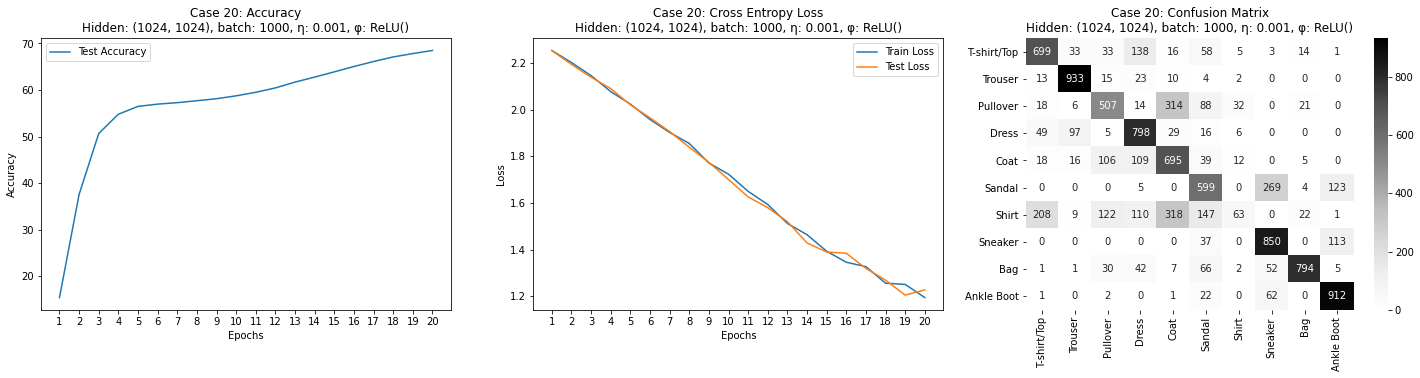

------------------------------------------------------------------------------------------
CASE: 21 Training Started: 01/26/2021 04:27:06
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 1.1926    Testing Loss: 1.1975    Testing Accuracy: 49.12%
Epoch 2/20  Training Loss: 1.0186    Testing Loss: 0.9790    Testing Accuracy: 62.03%
Epoch 3/20  Training Loss: 0.8287    Testing Loss: 0.7414    Testing Accuracy: 68.78%
Epoch 4/20  Training Loss: 0.6309    Testing Loss: 0.6596    Testing Accuracy: 73.13%
Epoch 5/20  Training Loss: 0.7575    Testing Loss: 0.6861    Testing Accuracy: 73.83%
Epoch 6/20  Training Loss: 0.5307    Testing Loss: 0.5526    Testing Accuracy: 80.04%
Epoch 7/20  Training Loss: 0.5407    Testing Loss: 0.584

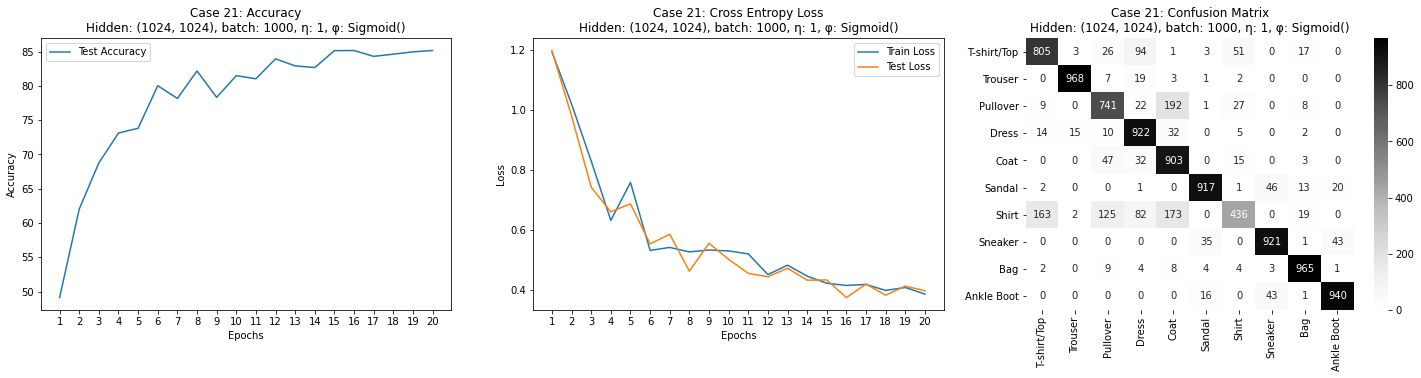

------------------------------------------------------------------------------------------
CASE: 22 Training Started: 01/26/2021 04:30:37
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 2.2840    Testing Loss: 2.2439    Testing Accuracy: 20.09%
Epoch 2/20  Training Loss: 1.6862    Testing Loss: 1.6758    Testing Accuracy: 47.23%
Epoch 3/20  Training Loss: 1.3057    Testing Loss: 1.3048    Testing Accuracy: 52.54%
Epoch 4/20  Training Loss: 1.0869    Testing Loss: 1.1011    Testing Accuracy: 61.61%
Epoch 5/20  Training Loss: 0.9851    Testing Loss: 1.0024    Testing Accuracy: 61.68%
Epoch 6/20  Training Loss: 0.8800    Testing Loss: 0.9389    Testing Accuracy: 66.09%
Epoch 7/20  Training Loss: 0.8273    Testing Loss: 0.8

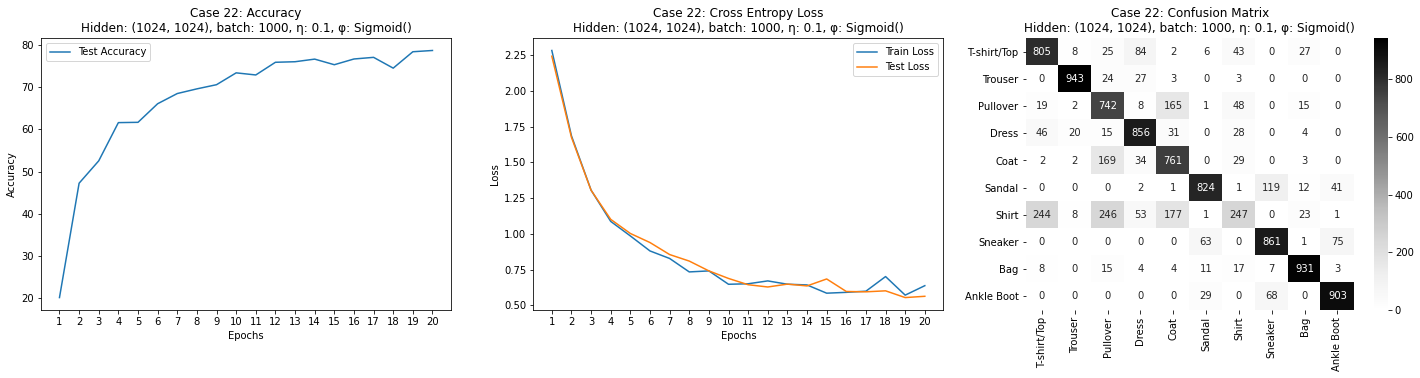

------------------------------------------------------------------------------------------
CASE: 23 Training Started: 01/26/2021 04:34:08
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 2.2944    Testing Loss: 2.2912    Testing Accuracy: 10.0%
Epoch 2/20  Training Loss: 2.2791    Testing Loss: 2.2785    Testing Accuracy: 17.67%
Epoch 3/20  Training Loss: 2.2641    Testing Loss: 2.2628    Testing Accuracy: 29.09%
Epoch 4/20  Training Loss: 2.2507    Testing Loss: 2.2498    Testing Accuracy: 38.08%
Epoch 5/20  Training Loss: 2.2339    Testing Loss: 2.2302    Testing Accuracy: 45.06%
Epoch 6/20  Training Loss: 2.2164    Testing Loss: 2.2137    Testing Accuracy: 42.49%
Epoch 7/20  Training Loss: 2.1962    Testing Loss: 2.1

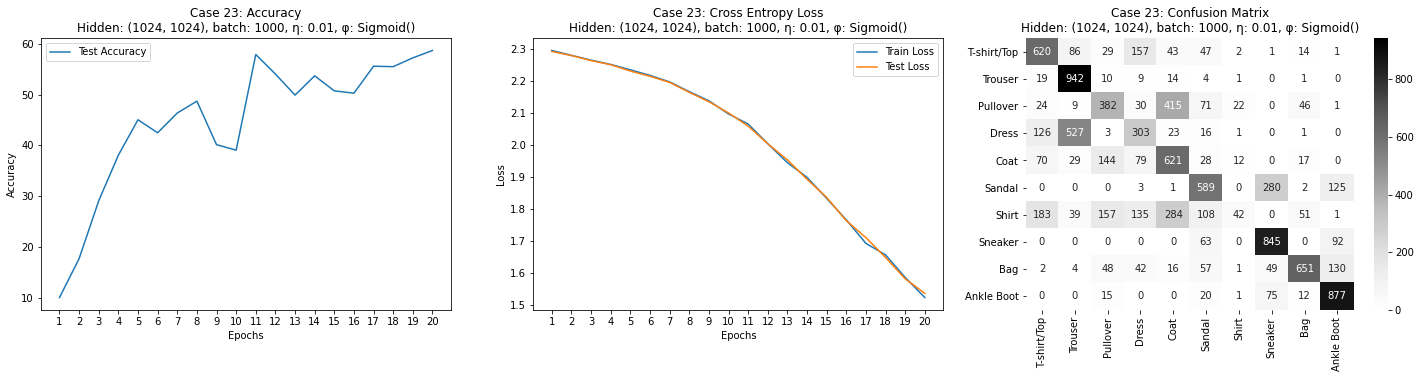

------------------------------------------------------------------------------------------
CASE: 24 Training Started: 01/26/2021 04:37:40
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 2.3078    Testing Loss: 2.3057    Testing Accuracy: 9.97%
Epoch 2/20  Training Loss: 2.3016    Testing Loss: 2.3012    Testing Accuracy: 5.88%
Epoch 3/20  Training Loss: 2.3001    Testing Loss: 2.2997    Testing Accuracy: 11.4%
Epoch 4/20  Training Loss: 2.2985    Testing Loss: 2.2983    Testing Accuracy: 16.81%
Epoch 5/20  Training Loss: 2.2969    Testing Loss: 2.2980    Testing Accuracy: 21.07%
Epoch 6/20  Training Loss: 2.2962    Testing Loss: 2.2956    Testing Accuracy: 23.43%
Epoch 7/20  Training Loss: 2.2945    Testing Loss: 2.29

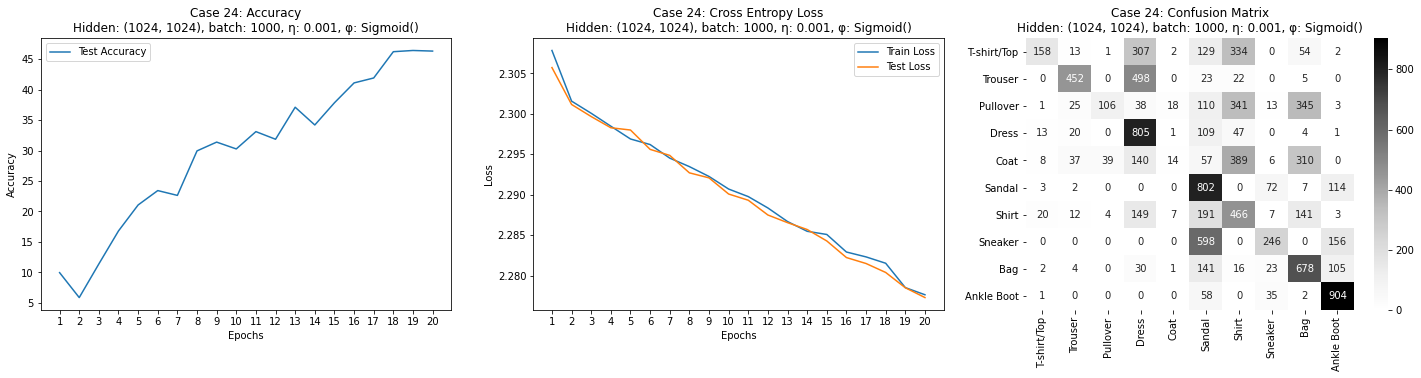

Total Elapsed Time: 6:17:09.124193




In [18]:
import time
import time as timer
import datetime
from datetime import timedelta

start = timer.time()
timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
timestamp = time.strftime("%Y%m%d-%H%M%S")
print(f"3*4*2=24 Model Training - Started At: {timestamp_pretty}")

hidden_size = (1024, 1024)
momentum = 0
epochs = EPOCHS

# for faster testing
# params = {
#     'batch_size': [1],
#     'activation': [nn.ReLU()],
#     'learn_rate': [1, 0.1],
# }

params = {
    'batch_size': [1, 10, 1000],
    'activation': [nn.ReLU(), nn.Sigmoid()],
    'learn_rate': [1, 0.1, 0.01, 0.001],
}

i = 0
for batch_size in params['batch_size']:
    for activation in params['activation']:
        for learn_rate in params['learn_rate']:
            i += 1
            start_iteration = timer.time()
            start_train = datetime.datetime.now()
            start_train_str = start_train.strftime("%m/%d/%Y %H:%M:%S")
            print("------------------------------------------------------------------------------------------")
            print(f"CASE: {i:02d} Training Started: {start_train_str}")
            print("------------------------------------------------------------------------------------------")

            model = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
            model.train(hidden_size=hidden_size, activation=activation,
                            learn_rate=learn_rate, momentum=momentum, epochs=epochs)

            elapsed = (time.time() - start_iteration)
            print(f"Completed Case {i}/24: {str(timedelta(seconds=elapsed))} Elapsed\n")

            display_model_visuals(model, f"Case {i:02d}");

elapsed = (time.time() - start)
print(f"Total Elapsed Time: {str(timedelta(seconds=elapsed))}\n\n")


## **4.	Training on Polluted Data**
**Instructions from Assignment:**<br>
*From 3 above, pick the best set of parameters for the 2 FC layer network. Pick 9 sets of 1% of images from each of the 10 categories and add them to the other 9 categories. This is called pollution. Run the best case on this data (training and then test on the unpolluted test data)*

I do not see any real change in accuracy.

I polluted 1% of the training data per instructions in the assignment handout.


In [19]:
# EPOCHS = 1
# EPOCHS = 2
EPOCHS = 20

--------------------------------------------------------
TestFashionModel.test_part1_polluted: 01/26/2021 04:41:11
--------------------------------------------------------
Hidden Layers: [1024]
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        20
------------------------------------------------------------------------------------------
Epoch 1/20  Training Loss: 0.5144    Testing Loss: 0.0000    Testing Accuracy: 85.4%
Epoch 2/20  Training Loss: 0.0007    Testing Loss: 0.0000    Testing Accuracy: 86.09%
Epoch 3/20  Training Loss: 0.0000    Testing Loss: 0.0038    Testing Accuracy: 87.72%
Epoch 4/20  Training Loss: 1.8437    Testing Loss: 0.0003    Testing Accuracy: 88.29%
Epoch 5/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 88.34%
Epoch 6/20  Training Loss: 0.0000    Testing Loss: 0.0066    Testing Accuracy: 88.59%
Epoch 7/20  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 88.98%
Epoch 8/20  Training Loss: 0.0000    

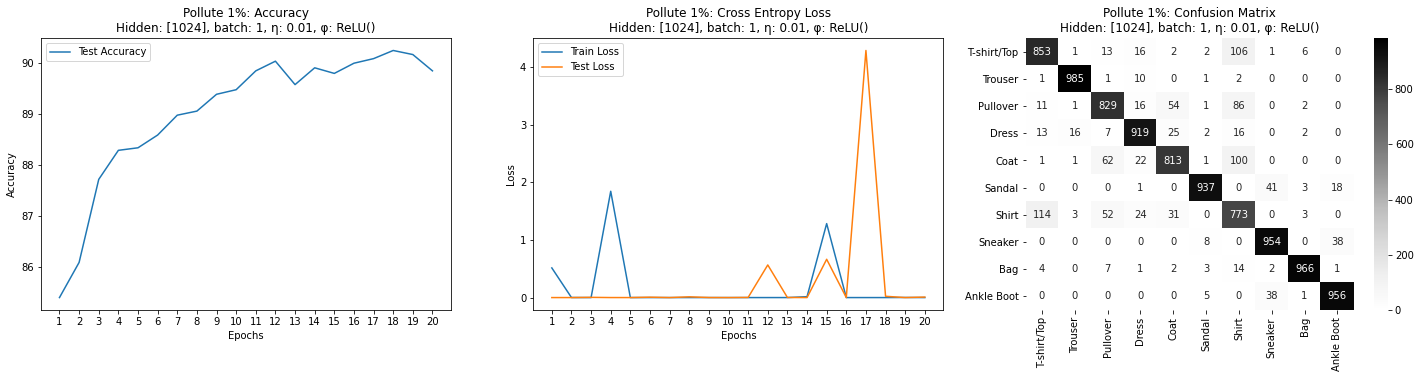

Time taken: 0:30:04.145588 Elapsed




In [20]:
start = timer.time()
timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
timestamp = time.strftime("%Y%m%d-%H%M%S")
print("--------------------------------------------------------")
print(f"TestFashionModel.test_part1_polluted: {timestamp_pretty}")
print("--------------------------------------------------------")

hidden_size = [1024]
batch_size = 1
learn_rate = 0.01
activation = nn.ReLU()
momentum = 0
epochs = EPOCHS

# Train the model
model_polluted = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_polluted.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

display_model_visuals(model_polluted, "Pollute 1%")

elapsed = (time.time() - start)
print(f"Time taken: {str(timedelta(seconds=elapsed))} Elapsed\n\n")